<a href="https://colab.research.google.com/github/diperezp/Analisis_Se-al_2025_1/blob/main/Convolucion/lab1/Convolucion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#$Convolucion$


In [19]:
#app_15.1
import torch       #torch
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim
from torchsummary import summary
from torch.autograd import Variable

##$Exploracion\ del\ dataset$




Shape train: torch.Size([60000, 28, 28])
Dim train: 3


Shape test: torch.Size([10000, 28, 28])
Dim test: 3


Shape de imagen de entrenamiento en la posición 50: torch.Size([1, 28, 28])
Dim de imagen de entrenamiento en la posición 50: torch.Size([1, 28, 28])
Etiqueta corresponsdiente a la imagen en la posición 50: 9


Los valores están ya normalizados entre -1 y 1:
Min: 0.0
Max: 1.0
Media: 0.13094238936901093


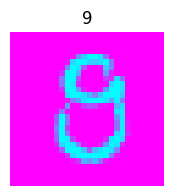

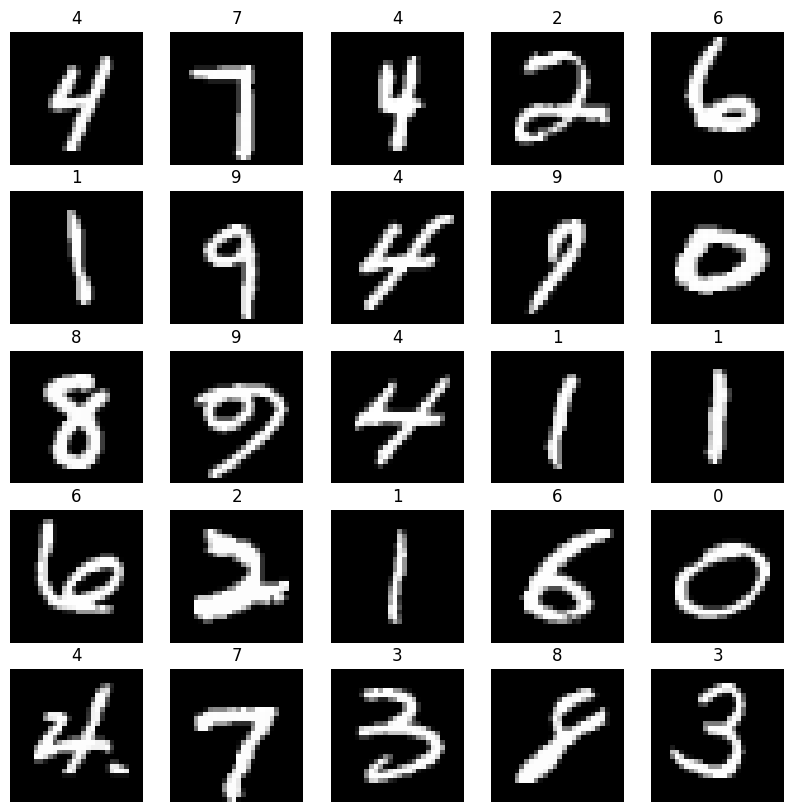

In [17]:
"""
EL DATASET
"""
# Cargar las imágenes MNIST.
# En la cargada se usó ToTensor para simultaneamente
# convertir las imágenes en tensores PyTorch
# normalizados [0.0, 1.0]
transform = transforms.Compose([transforms.Resize((28, 28)),transforms.ToTensor()])


train_data =datasets.MNIST('./data',train=True,transform=transform,download=True)
test_data =datasets.MNIST('./data',train=False,transform=transform,download=True)

# Explorar un poco el dataset
# Conjunto de entrenamiento
print("\n")
print("Shape train:", train_data.data.shape)
print("Dim train:", train_data.data.dim())
# Conjunto de testeo
print("\n")
print("Shape test:", test_data.data.shape)
print("Dim test:", test_data.data.dim())
# Explorar la imágen en la posición 50 de train
imagen, etiqueta = train_data[80]
print("\n")
print("Shape de imagen de entrenamiento en la posición 50:",imagen.shape)
print("Dim de imagen de entrenamiento en la posición 50:",imagen.shape)
print("Etiqueta corresponsdiente a la imagen en la posición 50:",etiqueta)
print("\n")
print("Los valores están ya normalizados entre -1 y 1:")
print(f"Min: {imagen.min()}")
print(f"Max: {imagen.max()}")
print(f"Media: {imagen.mean()}")
figure = plt.figure(figsize=(2, 2))
plt.title(etiqueta)
plt.axis("off")
# Matplotlib trabaja con la imagen (28,28,1 y Pytorch (1,28,28)
# por lo tanto hay que permutar
imagen = imagen.permute(1,2,0)
plt.imshow(imagen, cmap="cool_r")
plt.show()
# Desplegar un conjunto al azar de 25 imágenes de entrenamiento
figure = plt.figure(figsize=(10, 10))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    imagen, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    # Matplotlib trabaja con la imagen (28,28,1 y Pytorch (1,28,28)
    # por lo tanto hay que permutar
    imagen = imagen.permute(1,2,0)
    plt.imshow(imagen, cmap="gray")
plt.show()

##$Organizacion\ del\ dataset$

In [16]:
# Organizar el dataset en minilotes escogidos al azar para
# un mejor y mas rápido entrenamiento
torch.manual_seed(5) # semilla
loaders = {
'train' : torch.utils.data.DataLoader(train_data,
batch_size=32,
shuffle=True,
num_workers=0),
'test' : torch.utils.data.DataLoader(test_data,
batch_size=32,
shuffle=True,
num_workers=0),
}

##$primer\ acercamiento\ alas\ CNN$


In [20]:
# Por costumbre siempre indagar por la GPU, sin embargo, en este ejemplo se ejecutará en CPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
"""
EL DATASET
"""
# Cargar las imágenes MNIST.
# En la cargada se usó ToTensor para simultaneamente
# convertir las imágenes en tensores PyTorch
# normalizados [0.0, 1.0]
transform = transforms.Compose([transforms.Resize((28, 28)),transforms.ToTensor()])

# Organizar el dataset en minilotes escogidos al azar para
# un mejor y mas rápido entrenamiento
torch.manual_seed(5) # semilla

# tamaño del lote
# MNIST consiste de 60K imágenes de entrenamiento y 10K imágenes de testeo
# Se elgirá un batc_size de 100 para tener 600 lotes de imagenes para
# entrenamineto y 100 para testeo
BATCH_SIZE = 32   #100
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

"""
ARQUITECTURA DE LA RED CNN PROPUESTA
"""
class CNN_MNIST(nn.Module):
  def __init__(self):
    super(CNN_MNIST, self).__init__()
    # Declarar todas las capas para la extracción de características
    self.features = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 32, 5, 1, 2),
    nn.ReLU(),
    nn.MaxPool2d(2))
    # Declarar todas las capas para clasificación
    self.clasificacion = nn.Sequential(
    # fully connected layer, output 10 classes
    nn.Linear(32 * 7 * 7, 10)
    )
  def forward(self, x):
    # Apicar la extracción de características
    x = self.features(x)
    # Squeeze the three spatial dimensions in one
    x = x.view(x.size(0), -1)
    # Clasificar las imágenes
    output = self.clasificacion(x)
    return output

# Instanciar el modelo
cnn = CNN_MNIST()
"""
INFORMACIÓN DE LA ARQUITECTURA DE LA RED NEURONAL
"""
print("\n")
print("El modelo:\n\n",cnn)
# Para desplegar el resumen de parámetros se debe
#input_size = (tamaño del bathc, número de canales de las imagenes, tamaño de las imágenes)
print("\n")
print("Resumen de los parámetros:\n")
summary(cnn,input_size=(BATCH_SIZE, 1, 28, 28))

cpu


El modelo:

 CNN_MNIST(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (clasificacion): Sequential(
    (0): Linear(in_features=1568, out_features=10, bias=True)
  )
)


Resumen de los parámetros:



RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [2, 32, 1, 28, 28]